# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

En este cuaderno buscaremos elaborar un modelo predictivo utilizando Machine Learning para saber una estimación del precio de un determinado vehículo de segunda mano y poder optimizar la compraventa de coches.

Por esto, el objetivo es tener una plataforma web donde poder saber el precio de un determinado vehículo de segunda mano, en base al precio de otros coches registrados en nuestra base de datos. Para ello, se utilizan los registros guardados en la tabla TX_VEHICULOS_SEG_MANO de nuestra BBDD de sqlite, con cerca de 35.000 registros de vehículos de 10 marcas diferentes importadas desde un Dataset de Kaggle hecho a partir de WebScraping, a los que hemos añadido X vehículos scrapeados mediante el script guardado en la ruta ```"dags/webscraping_script.py"``` de la página de [coches.net](coches.net).

Los registros obtenidos mediante ambos orígenes de datos han sido posibles de combinar mediante las transformaciones realizadas en el cuaderno ```"notebooks/kaggle_dataset_cleaning.ipynb"```, aunque antes de entrenar el modelo predictivo será necesario realizar algunas transformaciones adicionales, así como seleccionar las features del modelo.

En este proyecto, se utilizarán modelos de Machine Learning para calcular el precio de un coche a partir de características como la marca, modelo, tipo de combustible, año, etc. Se trata, por tanto, de un problema de regresión. Se utilizará como métrica de optimización el Mean Squared Error (MSE), aunque también se analizarán otras métricas como el Mean Average Error (MAE).

## 2. Obtención y procesado de datos.

Importamos los datos desde nuestra base de datos:

In [158]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set_style("darkgrid")


colors = ["#d5001c", "#f59908", "#ffcb01", "#969696"]

In [159]:
import sqlite3
import pandas as pd

con = sqlite3.connect("../include/db_vehiculos.db")

query = """
SELECT *
FROM TX_VEHICULOS_SEG_MANO
where
    --origen_anuncio = 'WebScraping'
    --origen_anuncio = 'dataset kaggle'
    --and marca not in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
    marca in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT', 'HYUNDAI', 'KIA', 'NISSAN', 'TOYOTA')
order by
    fecha_carga desc
;
"""

df = pd.read_sql_query(query, con)

df.head()

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,Híbrido,2023.0,46273,110.0,5.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,Híbrido,2022.0,103209,120.0,5.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,Híbrido,2020.0,110745,122.0,5.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,Gasolina,2022.0,63000,114.0,5.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,Híbrido,2022.0,62765,140.0,5.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


Podemos ver el número de registros para cada origen de datos:

In [160]:
df['origen_anuncio'].value_counts()

origen_anuncio
dataset kaggle    40504
WebScraping        7550
Name: count, dtype: int64

Vemos que la gran mayoría de registros provienen del dataset de kaggle.

Vamos a ver qué columnas contiene el DataFrame:

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48054 entries, 0 to 48053
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        48054 non-null  int64  
 1   marca                48054 non-null  object 
 2   modelo               48054 non-null  object 
 3   precio               48054 non-null  float64
 4   combustible          47834 non-null  object 
 5   anyo_vehiculo        48052 non-null  float64
 6   kilometraje          48054 non-null  int64  
 7   potencia             40572 non-null  float64
 8   num_puertas          47939 non-null  float64
 9   num_plazas           7430 non-null   float64
 10  tipo_cambio          47963 non-null  object 
 11  tipo_vehiculo        7550 non-null   object 
 12  cilindrada_motor     7389 non-null   float64
 13  color                47339 non-null  object 
 14  provincia            48049 non-null  object 
 15  etiqueta_eco         5310 non-null  

Vemos que el DataFrame se compone de 21 columnas, de las cuales, muchas de ellas son de tipo string. Además, contienen valores nulos, por lo que, a continuación, haremos un procesado de estas columnas.

La columna target u objetivo a predecir es la columna llamada ```"precio"```.

Lo primero que haremos es eliminar las columnas ```['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco']```, ya que solo tienen valores no nulos para los registros obtenidos mediante WebScraping.

In [162]:
df = df.drop(columns=['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48054 entries, 0 to 48053
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        48054 non-null  int64  
 1   marca                48054 non-null  object 
 2   modelo               48054 non-null  object 
 3   precio               48054 non-null  float64
 4   combustible          47834 non-null  object 
 5   anyo_vehiculo        48052 non-null  float64
 6   kilometraje          48054 non-null  int64  
 7   potencia             40572 non-null  float64
 8   num_puertas          47939 non-null  float64
 9   tipo_cambio          47963 non-null  object 
 10  color                47339 non-null  object 
 11  provincia            48049 non-null  object 
 12  origen_anuncio       48054 non-null  object 
 13  fecha_publicacion    48054 non-null  object 
 14  anyomes_publicacion  48054 non-null  int64  
 15  fecha_carga          48054 non-null 

Vamos a eliminar también las columnas: ```['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url']```, ya que tampoco aportan información para el modelo.

De momento dejamos la columna ```'origen_anuncio'``` por si hay que distinguir en alguna transformación entre los datos de ambos orígenes.

In [163]:
df = df.drop(columns=['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48054 entries, 0 to 48053
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           48054 non-null  object 
 1   modelo          48054 non-null  object 
 2   precio          48054 non-null  float64
 3   combustible     47834 non-null  object 
 4   anyo_vehiculo   48052 non-null  float64
 5   kilometraje     48054 non-null  int64  
 6   potencia        40572 non-null  float64
 7   num_puertas     47939 non-null  float64
 8   tipo_cambio     47963 non-null  object 
 9   color           47339 non-null  object 
 10  origen_anuncio  48054 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 4.0+ MB


### Variable objetivo: precio.

Vamos a ver la distibución de datos de la columna target (```"precio"```):

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

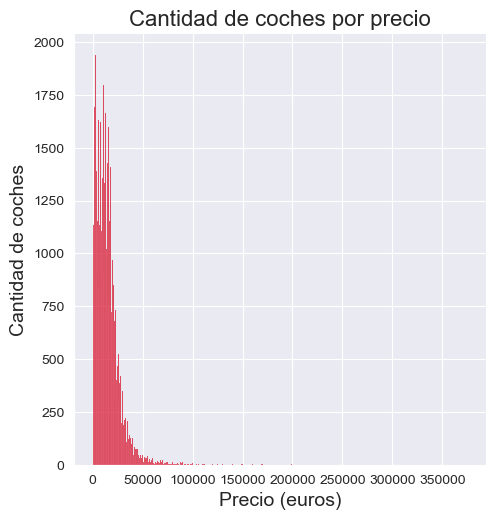

In [164]:
plt.figure(figsize=(8, 6))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio", fontsize=16)

plt.xlabel("Precio (euros)", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.show()

Vemos que existen muchos coches con un precio más bajo, y que, para precios más elevados, se reduce el número. Para corregir esto, y aumentar la eficacia del modelo predictivo, vamos a plantear dos medidas:

1. Realizar un boxplot para detectar outliers y poder eliminar estos registros.

2. Aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Comenzamos realizando el Boxplot:

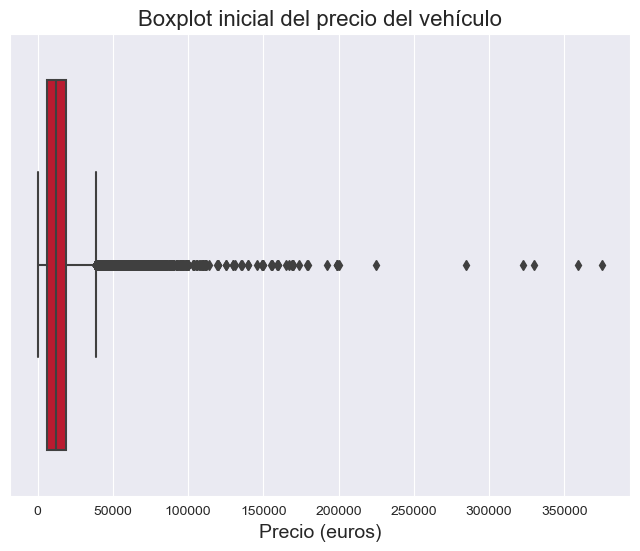

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Boxplot de la variable "precio"
sns.boxplot(x=df["precio"], color=colors[0])

# Títulos y etiquetas
plt.title("Boxplot inicial del precio del vehículo", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que la distribución del boxplot muestra que el 75 % de los registros se concentran por debajo de los 20.000 euros aproximadamente.

Vamos a ver las principales medidas estadísticas de la variable ```"precio"```:

In [166]:
df["precio"].describe()

count     48054.000000
mean      14414.755920
std       12638.661242
min         300.000000
25%        6000.000000
50%       12450.000000
75%       18990.000000
max      375000.000000
Name: precio, dtype: float64

In [167]:
# df = df.loc[df.loc[:, "precio"] < 101000, :]

Observamos que la variable tiene una media de 14.414 euros y una desviación estándar (sigma) de 12.638 euros. Sin embargo, el valor máximo es de 375.000 euros.

Ante esto, vamos a proponer dos opciones para eliminar outliers que puedan influir negativamente en el modelo o para los cuáles funcione muy mal.

1. Coger los valores dentro de los siguientes límites a partir del Rango intercuartílico (IQR), que marcarían los outliers tradicionales:

    - limite_inferior = Q1 - 1.5 * IQR
    - limite_superior = Q3 + 1.5 * IQR

Probamos esta opción:


Opción con cuartiles:

In [168]:
# Calculamos Q1, Q3 e IQR
Q1 = df["precio"].quantile(0.25)
Q3 = df["precio"].quantile(0.75)
IQR = Q3 - Q1

# Límites inferior y superior para considerar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Límite de precio inferior: {limite_inferior}")
print(f"Límite de precio superior: {limite_superior}")

df_iqr = df[(df["precio"] >= limite_inferior) & (df["precio"] <= limite_superior)]

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_iqr)}")


Límite de precio inferior: -13485.0
Límite de precio superior: 38475.0
Número de coches antes de eliminar outliers: 48054
Número de coches después de eliminar outliers: 46337


Si utilizamos esta opción seguro que el modelo funciona muy bien pero solo predeciríamos vehículos con precios hasta 38.475 euros, lo que dejaría fuera muchos modelos.

Por ello, vamos a descartar esta opción.

Probaremos una segunda opción que consiste en aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. Después, nos quedaremos con los vehículos en un rango de valores del precio transformado de 2 desviaciones estandar a partir de la media, que coresponderá a un porcentaje muy elevado de los datos.

Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

Aplicamos la transformación logarítmica:

In [169]:
import numpy as np

# Transformación logarítmica del precio:
df["precio"] = np.log(df["precio"])

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 800x600 with 0 Axes>

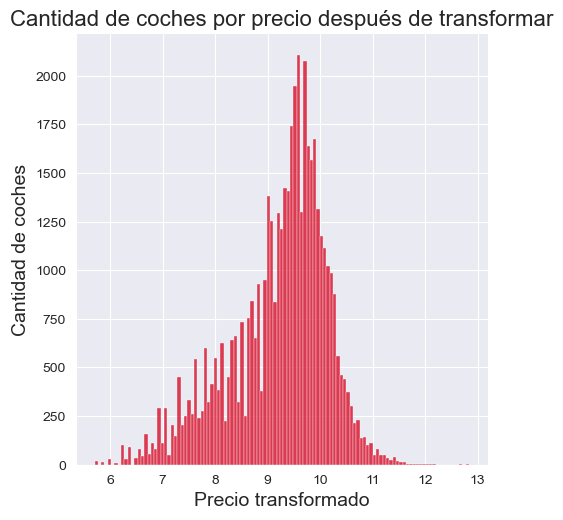

In [170]:
plt.figure(figsize=(8, 6))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio después de transformar", fontsize=16)

plt.xlabel("Precio transformado", fontsize=14)
plt.ylabel("Cantidad de coches", fontsize=14)

plt.yticks(range(0, 2250, 250))

plt.show()

Test de normalidad de Shapiro-Wilk:

In [171]:
from scipy.stats import shapiro

# Aplicar el test de Shapiro-Wilk a una muestra (máx. 5000 datos recomendado)
sample = df["precio"].sample(n=5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p_value:.38f}")

if p_value > 0.05:
    print("No se rechaza H₀: los datos podrían ser normales.")
else:
    print("Se rechaza H₀: los datos no siguen una distribución normal.")


Estadístico W: 0.9555
Valor p: 0.00000000000000000000000000000000000141
Se rechaza H₀: los datos no siguen una distribución normal.


Nos quedamos con los valores dentro del límite superior de 2 sigmas:

In [172]:
mean_log = df["precio"].mean()
std_log = df["precio"].std()

# Límite superior a 2 sigmas en escala logarítmica:
upper_log_limit = mean_log + 2 * std_log

# Filtramos solo los valores dentro de las 2 sigmas:
df_filtrado = df[df["precio"] <= upper_log_limit]

# (Opcional) Si necesitamos volver a la escala original:
max_precio_filtrado = np.exp(upper_log_limit)

num_coches_eliminados = len(df) - len(df_filtrado)

print(f"Límite superior en escala log: {upper_log_limit:.4f}")
print(f"Corresponde a un precio real de: {max_precio_filtrado:,.2f} €")

print(f"Número de coches antes de eliminar outliers: {len(df)}")
print(f"Número de coches después de eliminar outliers: {len(df_filtrado)}")
print(f"Número de coches eliminados: {num_coches_eliminados}")


Límite superior en escala log: 11.0968
Corresponde a un precio real de: 65,958.83 €
Número de coches antes de eliminar outliers: 48054
Número de coches después de eliminar outliers: 47710
Número de coches eliminados: 344


In [173]:
# Estadísticos de la variable precio transfromada:

df["precio"].describe()

count    48054.000000
mean         9.218982
std          0.938902
min          5.703782
25%          8.699515
50%          9.429476
75%          9.851668
max         12.834681
Name: precio, dtype: float64

Vemos que se eliminan 344 registros. Vamos a aplicar la transformación al df original y a ver los valores estadísticos transformados de nuevo, para ver que se ha realizado correctamente:

In [174]:
# Aplicamos el filtro de las 2 sigmas al df original:
df = df[df["precio"] <= upper_log_limit]

# Nuevos estadísticos tras el filtro:
df["precio"].describe()

count    47710.000000
mean         9.203380
std          0.923700
min          5.703782
25%          8.699348
50%          9.416541
75%          9.846917
max         11.096652
Name: precio, dtype: float64

Estos son los estadísticos que contiene la columna ```df["precio"]```, que ahora están en escala logarítmica, vamos a verlos en escala normal deshaciendo la transformación:

In [175]:
import numpy as np

# Mostramos el resumen estadístico con la transformación inversa (precio real)
print(np.exp(df["precio"]).describe())

count    47710.000000
mean     13848.159296
std      10199.125277
min        300.000000
25%       5999.000000
50%      12290.000000
75%      18900.000000
max      65950.000000
Name: precio, dtype: float64


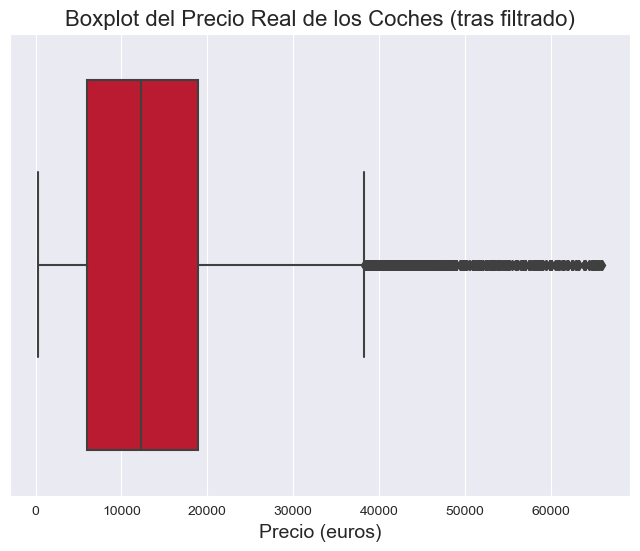

In [176]:
plt.figure(figsize=(8, 6))

# Boxplot con la transformación inversa de log(precio)
sns.boxplot(x=np.exp(df["precio"]), color=colors[0])

plt.title("Boxplot del Precio Real de los Coches (tras filtrado)", fontsize=16)
plt.xlabel("Precio (euros)", fontsize=14)

plt.show()


Vemos que sólo hemos perdido 269 vehículos pero ahora el precio máximo es de 65.950 euros, lo que comprende más vehículos y elimina outliers que el modelo podría predecir mal.

In [177]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,AUDI,a3,10.138164,Híbrido,2023.0,46273,110.0,5.0,Automático,negro,WebScraping
1,HYUNDAI,i30,9.605755,Híbrido,2022.0,103209,120.0,5.0,Manual,None,WebScraping
2,TOYOTA,c-hr,9.908475,Híbrido,2020.0,110745,122.0,5.0,Automático,blanco,WebScraping
3,NISSAN,juke,9.797571,Gasolina,2022.0,63000,114.0,5.0,Automático,None,WebScraping
4,NISSAN,qashqai,10.101928,Híbrido,2022.0,62765,140.0,5.0,Manual,negro,WebScraping


Vemos que el precio ya no está en euros. Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

### Variables numéricas:

#### Potencia:

Vamos a analizar los nulos de la columna ```'potencia'```, a ver si son debidos al tipo de combustible o simplemente falta en esos registros.

In [178]:
df.groupby("combustible")["potencia"].apply(lambda x: x.isnull().sum())

combustible
Diesel                   3
Diésel                5237
Eléctrico                0
Gas licuado (GLP)        0
Gas natural (CNG)        0
Gasolina              2088
Híbrido                  0
Híbrido Enchufable       0
Híbrido enchufable       0
Name: potencia, dtype: int64

Como parece que hay varios formatos de la columna combustible, vamos a mapearlos:

In [179]:

mapa_combustible = {
    "Diesel": "Diésel",
    "Híbrido enchufable": "Híbrido Enchufable",
    "Híbrido Enchufable": "Híbrido Enchufable"
}

df["combustible"] = df["combustible"].replace(mapa_combustible)

In [180]:
df["combustible"].value_counts()

combustible
Diésel                28753
Gasolina              15736
Híbrido                1988
Híbrido Enchufable      463
Eléctrico               443
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

In [181]:
df[df["potencia"].isna()].groupby("combustible").size()

combustible
Diésel      5240
Gasolina    2088
dtype: int64

Observamos que todos los nulos son para vehículos de gasolina o diésel, por lo que vamos a eliminar estos registros del DataFrame, ya que tenemos una cantidad de datos abundante y puede ser un parámetro sensible en el modelo, por lo que tratar de rellenar esos NaN por alguna métrica como la media, puede afectar negativamente.

In [182]:
df = df.drop(index=(df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,AUDI,a3,10.138164,Híbrido,2023.0,46273,110.0,5.0,Automático,negro,WebScraping
1,HYUNDAI,i30,9.605755,Híbrido,2022.0,103209,120.0,5.0,Manual,None,WebScraping
2,TOYOTA,c-hr,9.908475,Híbrido,2020.0,110745,122.0,5.0,Automático,blanco,WebScraping
3,NISSAN,juke,9.797571,Gasolina,2022.0,63000,114.0,5.0,Automático,None,WebScraping
4,NISSAN,qashqai,10.101928,Híbrido,2022.0,62765,140.0,5.0,Manual,negro,WebScraping


c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


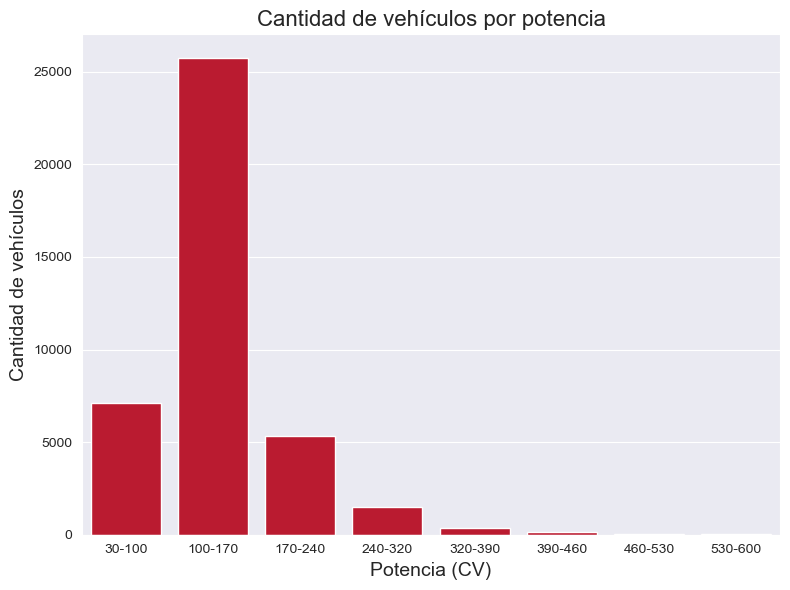

In [183]:
# Definimos los rangos de potencia:
min_potencia = df['potencia'].min()
max_potencia = df['potencia'].max()

num_bins = 8

bins = np.linspace(min_potencia, max_potencia, num_bins + 1) 
bins = np.round(bins, -1) 

labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

df_rangos = df.copy() 
df_rangos['potencia_rango'] = pd.cut(df_rangos['potencia'], bins=bins, labels=labels, right=False)

plt.figure(figsize = (8, 6))

sns.countplot(x=df_rangos["potencia_rango"], order=labels, color=colors[0])

plt.title("Cantidad de vehículos por potencia", fontsize=16)
plt.xlabel("Potencia (CV)", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
# plt.xticks(rotation=45)  

plt.xticks(ha='center') 
plt.tight_layout()

plt.show()

In [184]:
# Num de vehículos con potncia > 330 CV:

df.loc[df.loc[:, "potencia"] > 330, :].count()

marca             487
modelo            487
precio            487
combustible       487
anyo_vehiculo     487
kilometraje       487
potencia          487
num_puertas       487
tipo_cambio       487
color             487
origen_anuncio    487
dtype: int64

In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40234 entries, 0 to 48053
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40234 non-null  object 
 1   modelo          40234 non-null  object 
 2   precio          40234 non-null  float64
 3   combustible     40162 non-null  object 
 4   anyo_vehiculo   40232 non-null  float64
 5   kilometraje     40234 non-null  int64  
 6   potencia        40234 non-null  float64
 7   num_puertas     40234 non-null  float64
 8   tipo_cambio     40143 non-null  object 
 9   color           40059 non-null  object 
 10  origen_anuncio  40234 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.7+ MB


#### Año:

In [186]:
# Vemos si hay alguno nulo:

df[df["anyo_vehiculo"].isna()]

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
36986,SEAT,arona,10.021271,Gasolina,NaN,1,115.0,5.0,Manual,naranja,dataset kaggle
45971,KIA,stonic,9.732106,Gasolina,NaN,1,100.0,5.0,Manual,signal,dataset kaggle


Vamos a ver la distribución de valores del campo ```"anyo_vehiculo"```.

Hay dos con valor nulo. Lo eliminamos y convertimos el resto a int:

In [187]:
df = df.dropna(subset=["anyo_vehiculo"])

df["anyo_vehiculo"] = df["anyo_vehiculo"].astype(int)

In [188]:
df["anyo_vehiculo"].value_counts()

anyo_vehiculo
2016    4621
2019    4503
2020    4094
2017    3922
2018    3567
2015    2684
2014    1703
2021    1292
2013    1244
2011    1125
2007    1123
2008    1099
2010    1081
2012    1052
2009     988
2006     948
2005     855
2004     679
2022     656
2024     478
2003     476
2023     454
2002     351
2001     281
2000     239
1999     182
1998     105
1997      72
1996      58
2025      43
1993      42
1995      35
1992      34
1994      30
1991      26
1989      25
1990      17
1988      11
1987      10
1986       8
1982       7
1985       5
1984       3
1983       3
1980       1
Name: count, dtype: int64

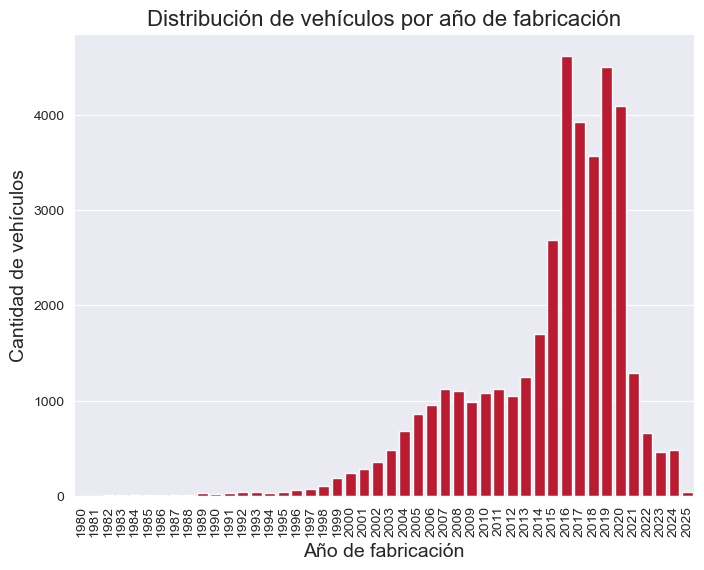

In [189]:
plt.figure(figsize = (8, 6))

rango_años = np.linspace(df["anyo_vehiculo"].min(), df["anyo_vehiculo"].max(), num=int(df["anyo_vehiculo"].max() - df["anyo_vehiculo"].min()) + 1, dtype=int)


sns.countplot(x=df["anyo_vehiculo"], order=rango_años, color=colors[0])

plt.title("Distribución de vehículos por año de fabricación", fontsize=16)
plt.xlabel("Año de fabricación", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=90)  

plt.show()

#### Número de puertas:

Veamos los valores de la siguiente columna no numérica, ```"num_puertas"```:

In [190]:
df["num_puertas"] = df["num_puertas"].astype(int)

df["num_puertas"].value_counts()

num_puertas
5    30579
4     5629
3     2469
2     1555
Name: count, dtype: int64

Vamos a agrupar los coches de 5 puertas con los de 4, y los de 3 con los de 2, ya que la diferencia es que no se cuenta el maletero.

In [191]:
num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
                     
df["num_puertas"] = df["num_puertas"].map(num_puertas)

In [192]:
df["num_puertas"].value_counts()

num_puertas
5    36208
3     4024
Name: count, dtype: int64

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40232 entries, 0 to 48053
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40232 non-null  object 
 1   modelo          40232 non-null  object 
 2   precio          40232 non-null  float64
 3   combustible     40160 non-null  object 
 4   anyo_vehiculo   40232 non-null  int32  
 5   kilometraje     40232 non-null  int64  
 6   potencia        40232 non-null  float64
 7   num_puertas     40232 non-null  int64  
 8   tipo_cambio     40141 non-null  object 
 9   color           40057 non-null  object 
 10  origen_anuncio  40232 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 3.5+ MB


### Variables categóricas:

#### Color:

La columna ```"color"``` sigue teniendo bastantes NaN.

In [194]:
# pd.set_option("display.max_rows", None)

df["color"].value_counts()

color
blanco    11428
gris       9567
negro      6298
azul       4508
rojo       2591
          ...  
b50           1
0j0j          1
m05l          1
gr5           1
1e0           1
Name: count, Length: 408, dtype: int64

Vamos a eliminar la columna color, ya que es una columna categórica con 323 valores únicos y algunos pueden estar en una codificación numérica y otros están mal guardados.

In [195]:
df = df.drop(columns="color")

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40232 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40232 non-null  object 
 1   modelo          40232 non-null  object 
 2   precio          40232 non-null  float64
 3   combustible     40160 non-null  object 
 4   anyo_vehiculo   40232 non-null  int32  
 5   kilometraje     40232 non-null  int64  
 6   potencia        40232 non-null  float64
 7   num_puertas     40232 non-null  int64  
 8   tipo_cambio     40141 non-null  object 
 9   origen_anuncio  40232 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 3.2+ MB


#### Tipo de cambio:

La columna ```"tipo_cambio"``` también continúa teniendo bastantes NaN.

In [197]:
df["tipo_cambio"].value_counts(dropna=False)

tipo_cambio
Manual        27514
Automático    12627
None             91
Name: count, dtype: int64

Como en la columna ```"tipo_cambio"``` existen muchos coches manuales y automáticos, vamos a eliminar las filas con valores de ```"tipo_cambio"``` nulos (91).

In [198]:
df = df.drop(index=(df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,AUDI,a3,10.138164,Híbrido,2023,46273,110.0,5,Automático,WebScraping
1,HYUNDAI,i30,9.605755,Híbrido,2022,103209,120.0,5,Manual,WebScraping
2,TOYOTA,c-hr,9.908475,Híbrido,2020,110745,122.0,5,Automático,WebScraping
3,NISSAN,juke,9.797571,Gasolina,2022,63000,114.0,5,Automático,WebScraping
4,NISSAN,qashqai,10.101928,Híbrido,2022,62765,140.0,5,Manual,WebScraping


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40141 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40141 non-null  object 
 1   modelo          40141 non-null  object 
 2   precio          40141 non-null  float64
 3   combustible     40069 non-null  object 
 4   anyo_vehiculo   40141 non-null  int32  
 5   kilometraje     40141 non-null  int64  
 6   potencia        40141 non-null  float64
 7   num_puertas     40141 non-null  int64  
 8   tipo_cambio     40141 non-null  object 
 9   origen_anuncio  40141 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 3.2+ MB


Ahora que ya no contiene nulos, convertimos a numéricos los valores de la columna ```"tipo_cambio"```, mapeando como 0 los vehículos con cambio "Manual" y 1 los que tienen "Automático":

In [200]:
df["tipo_cambio"].value_counts()

tipo_cambio
Manual        27514
Automático    12627
Name: count, dtype: int64

In [201]:
df["tipo_cambio"] = df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

In [202]:
df["tipo_cambio"].value_counts()

tipo_cambio
0    27514
1    12627
Name: count, dtype: int64

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40141 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40141 non-null  object 
 1   modelo          40141 non-null  object 
 2   precio          40141 non-null  float64
 3   combustible     40069 non-null  object 
 4   anyo_vehiculo   40141 non-null  int32  
 5   kilometraje     40141 non-null  int64  
 6   potencia        40141 non-null  float64
 7   num_puertas     40141 non-null  int64  
 8   tipo_cambio     40141 non-null  int64  
 9   origen_anuncio  40141 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


#### Combustible:

In [204]:
df[df["combustible"].isna()].count()

marca             72
modelo            72
precio            72
combustible        0
anyo_vehiculo     72
kilometraje       72
potencia          72
num_puertas       72
tipo_cambio       72
origen_anuncio    72
dtype: int64

Todavía hay 34 registros con el valor de combustible nulo, de modo que eliminamos estos registros:

In [205]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40069 non-null  object 
 1   modelo          40069 non-null  object 
 2   precio          40069 non-null  float64
 3   combustible     40069 non-null  object 
 4   anyo_vehiculo   40069 non-null  int32  
 5   kilometraje     40069 non-null  int64  
 6   potencia        40069 non-null  float64
 7   num_puertas     40069 non-null  int64  
 8   tipo_cambio     40069 non-null  int64  
 9   origen_anuncio  40069 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


Vemos que nos hemos quedado con 40.069 filas de 14 marcas de vehículos. Ya no tenemos valores nulos, ahora vamos a procesar las columnas restantes para que puedan ser usadas en el modelo.

In [206]:
df["combustible"].value_counts()

combustible
Diésel                23448
Gasolina              13626
Híbrido                1986
Híbrido Enchufable      461
Eléctrico               441
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

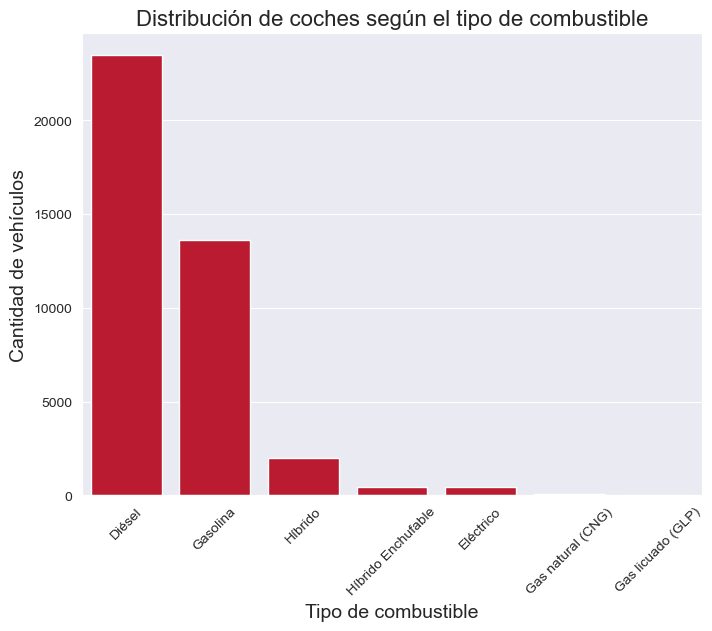

In [207]:
plt.figure(figsize = (8, 6))

sns.countplot(x=df["combustible"], order=df["combustible"].value_counts(ascending=False).index, color=colors[0])

plt.title("Distribución de coches según el tipo de combustible", fontsize=16)
plt.xlabel("Tipo de combustible", fontsize=14)
plt.ylabel("Cantidad de vehículos", fontsize=14)
plt.xticks(rotation=45)  

plt.show()

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40069 non-null  object 
 1   modelo          40069 non-null  object 
 2   precio          40069 non-null  float64
 3   combustible     40069 non-null  object 
 4   anyo_vehiculo   40069 non-null  int32  
 5   kilometraje     40069 non-null  int64  
 6   potencia        40069 non-null  float64
 7   num_puertas     40069 non-null  int64  
 8   tipo_cambio     40069 non-null  int64  
 9   origen_anuncio  40069 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(4)
memory usage: 3.2+ MB


Vamos ahora a convertir la columna ```"combustible"``` en numérica a través de un mapeado:

In [209]:
df["combustible"].value_counts()

combustible
Diésel                23448
Gasolina              13626
Híbrido                1986
Híbrido Enchufable      461
Eléctrico               441
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

Vemos cómo predominan los coches de diésel y gasolina.

Convertimos los valores en numéricos utilizando un mapeado:

In [210]:
# Aplicamos un mapeado para la columna "combustible":

tipos_combutible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido Enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
df["combustible"] = df["combustible"].map(tipos_combutible)

In [211]:
df["combustible"].value_counts()

combustible
0    23448
1    13626
2     1986
4      461
3      441
6       58
5       49
Name: count, dtype: int64

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40069 non-null  object 
 1   modelo          40069 non-null  object 
 2   precio          40069 non-null  float64
 3   combustible     40069 non-null  int64  
 4   anyo_vehiculo   40069 non-null  int32  
 5   kilometraje     40069 non-null  int64  
 6   potencia        40069 non-null  float64
 7   num_puertas     40069 non-null  int64  
 8   tipo_cambio     40069 non-null  int64  
 9   origen_anuncio  40069 non-null  object 
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 3.2+ MB


#### Marca:

Antes de convertir las columnas ```"marca"``` y ```"modelo"``` en númericas, vamos a guardar en un set las marcas y modelos de coches que quedan en el DataFrame, para luego utilizarlas en la Web App de predicción de precios:

In [213]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,AUDI,a3,10.138164,2,2023,46273,110.0,5,1,WebScraping
1,HYUNDAI,i30,9.605755,2,2022,103209,120.0,5,0,WebScraping
2,TOYOTA,c-hr,9.908475,2,2020,110745,122.0,5,1,WebScraping
3,NISSAN,juke,9.797571,1,2022,63000,114.0,5,1,WebScraping
4,NISSAN,qashqai,10.101928,2,2022,62765,140.0,5,0,WebScraping


In [214]:
marca_modelo_set = {}

for index, row in df.iterrows():
    make = row['marca']
    model = row['modelo']
    
    if make not in marca_modelo_set:
        marca_modelo_set[make] = {model}
    else:
        marca_modelo_set[make].add(model)

# Guardamos el set con marcas y modelos en un pkl:

with open('../include/utils/marca_modelo_set.pkl', 'wb') as archivo_salida3:
    pickle.dump(marca_modelo_set, archivo_salida3)

print(marca_modelo_set)

{'AUDI': {'90', 'q3 sportback', 'a2', 's6', 'r8', 'q3', 'rs4', '100', 'q7', 'allroad quattro', 'a1', 'tt', 's4', 'q2', 'rs7', 'a3', 'sq5', 'tts', 'rs3', 'rs6', 'a7', 'coupe', 'rs5', 'a5', 'a6 allroad quattro', 's7', 'sq7', 's3', 'a4', 'rs q3', 's5', 'a8', 'a6', 'q5', 'a4 allroad quattro', 'tt rs', 's8', 'cabriolet'}, 'HYUNDAI': {'i20', 'tucson', 'getz', 'santa fe', 'accent', 'i40', 'genesis', 'ix55', 'ioniq', 'ix20', 'atos', 'Bayon 1.2 MPI Maxx', 'i30', 'ix35', 'Bayon 1.0 TGDI Maxx', 'h-1 travel', 'grand santa fe', 'coupe', 'veloster', 'trajet', 'i20 active', 'h-1', 'atos prime', 'lantra', 'matrix', 'terracan', 'i10', 'elantra', 'sonata', 'h350', 'xg', 'kona'}, 'TOYOTA': {'rav4', 'yaris', 'avensis verso', 'gr yaris', 'CHR 2.0 180H Advance', '4runner', 'corolla', 'verso', 'hilux', 'land cruiser 200', 'corolla sedan', 'proace verso', 'dyna', 'proace city verso', 'c-hr', 'Priusplus Advance', 'urban cruiser', 'celica', 'prius+', 'auris', 'gt86', 'land cruiser 90', 'camry', 'previa', 'avens

Una vez guardado este set, empezamos con el análisis y procesado de las variables que utilizaremos en el modelo:

In [215]:
marca_df = df["marca"]
marca_df.value_counts()

marca
VOLKSWAGEN       4312
BMW              3994
MERCEDES-BENZ    3806
AUDI             3323
PEUGEOT          3109
FORD             2947
RENAULT          2947
OPEL             2869
CITROEN          2838
SEAT             2520
TOYOTA           2197
NISSAN           2113
HYUNDAI          1584
KIA              1510
Name: count, dtype: int64

Tenemos 14 marcas diferentes de coches. Vamos a hacer un countplot para ver cuántos vehículos tenemos de cada marca:

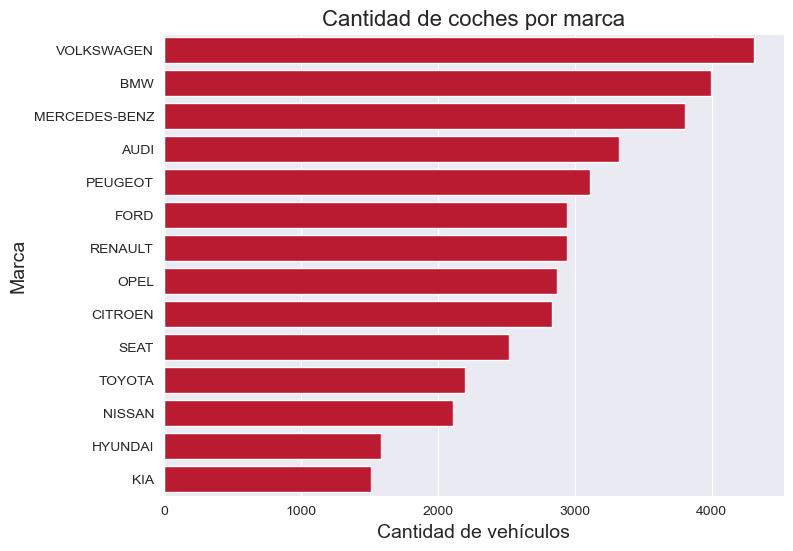

In [216]:
plt.figure(figsize = (8, 6))
sns.countplot(y = marca_df, order=marca_df.value_counts(ascending=False).index, color=colors[0])

plt.title("Cantidad de coches por marca", fontsize=16)
plt.xlabel("Cantidad de vehículos", fontsize=14)
plt.ylabel("Marca", fontsize=14)

plt.show()

En el gráfico vemos cómo tenemos muchos coches registrados en la base de datos para cada una de las 14 marcas.

Vamos a asignar un valor numérico a cada marca para poder utilizar dicha columna como feature del modelo:

In [217]:
# Asignamos cada marca a un valor numérico utilizando LabelEncoder:

from sklearn.preprocessing import LabelEncoder

encoder_marca = LabelEncoder()
encoder_marca.fit(df["marca"].sort_values(ascending=False))
list(encoder_marca.classes_)
df["marca"] = encoder_marca.transform(df["marca"])

# Guardamos el LabelEncoder para poder utilizarlo después en otros archivos:

with open('../include/utils/label_encoder_marca.pkl', 'wb') as archivo_salida1:
    pickle.dump(encoder_marca, archivo_salida1)

df["marca"].value_counts()

marca
13    4312
1     3994
6     3806
0     3323
9     3109
3     2947
10    2947
8     2869
2     2838
11    2520
12    2197
7     2113
4     1584
5     1510
Name: count, dtype: int64

In [218]:
# muestra las marcas originales

print(encoder_marca.classes_)


['AUDI' 'BMW' 'CITROEN' 'FORD' 'HYUNDAI' 'KIA' 'MERCEDES-BENZ' 'NISSAN'
 'OPEL' 'PEUGEOT' 'RENAULT' 'SEAT' 'TOYOTA' 'VOLKSWAGEN']


In [219]:
# Para visualizar el mapping de marca con LabelEncoder

list(encoder_marca.inverse_transform([0]))

['AUDI']

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40069 non-null  int32  
 1   modelo          40069 non-null  object 
 2   precio          40069 non-null  float64
 3   combustible     40069 non-null  int64  
 4   anyo_vehiculo   40069 non-null  int32  
 5   kilometraje     40069 non-null  int64  
 6   potencia        40069 non-null  float64
 7   num_puertas     40069 non-null  int64  
 8   tipo_cambio     40069 non-null  int64  
 9   origen_anuncio  40069 non-null  object 
dtypes: float64(2), int32(2), int64(4), object(2)
memory usage: 3.1+ MB


#### Modelo:

Vamos ahora con la columna ```"modelo"```:

In [221]:
df["modelo"].value_counts()

modelo
golf       1433
serie 3    1036
qashqai    1032
ibiza       872
focus       850
           ... 
corrado       1
r8            1
505           1
260           1
pick-up       1
Name: count, Length: 526, dtype: int64

Tenemos 526 modelos diferentes. En esta ocasión no realizamos el countplot ya que es información demasiado específica para visualizar.

Aunque son muchos valores diferentes, por el momento, realizamos otro Label Encoder. Más adelante veremos si es una columna que aporte información al modelo.

In [222]:
from sklearn.preprocessing import LabelEncoder

encoder_modelo = LabelEncoder()
encoder_modelo.fit(df["modelo"].sort_values(ascending=False))
list(encoder_modelo.classes_)
df["modelo"] = encoder_modelo.transform(df["modelo"])

# Guardamos el Encoding:

with open('../include/utils/label_encoder_modelo.pkl', 'wb') as archivo_salida2:
    pickle.dump(encoder_modelo, archivo_salida2)

df["modelo"].value_counts()

modelo
253    1433
439    1036
401    1032
286     872
242     850
       ... 
203       1
408       1
45        1
22        1
377       1
Name: count, Length: 526, dtype: int64

In [223]:
# Para visualizar el mapping de model con LabelEncoder

list(encoder_modelo.inverse_transform([196]))

['combo life']

In [225]:
encoder_modelo.transform(["A2"])

ValueError: y contains previously unseen labels: 'A2'

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           40069 non-null  int32  
 1   modelo          40069 non-null  int32  
 2   precio          40069 non-null  float64
 3   combustible     40069 non-null  int64  
 4   anyo_vehiculo   40069 non-null  int32  
 5   kilometraje     40069 non-null  int64  
 6   potencia        40069 non-null  float64
 7   num_puertas     40069 non-null  int64  
 8   tipo_cambio     40069 non-null  int64  
 9   origen_anuncio  40069 non-null  object 
dtypes: float64(2), int32(3), int64(4), object(1)
memory usage: 2.9+ MB


#### Origen anuncio:

Tan solo falta la columna ```"origen_anuncio"```, que vamos a eliminar ya que sólo la hemos mantenido para diferenciar el origen del anuncio, pero no la queremos utilizar en el modelo predictivo.

In [70]:
df.drop(columns=["origen_anuncio"], inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40069 entries, 0 to 48053
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   marca          40069 non-null  int32  
 1   modelo         40069 non-null  int32  
 2   precio         40069 non-null  float64
 3   combustible    40069 non-null  int64  
 4   anyo_vehiculo  40069 non-null  int32  
 5   kilometraje    40069 non-null  int64  
 6   potencia       40069 non-null  float64
 7   num_puertas    40069 non-null  int64  
 8   tipo_cambio    40069 non-null  int64  
dtypes: float64(2), int32(3), int64(4)
memory usage: 2.6 MB


Ya tenemos nuestro DataFrame con todas las columnas de tipo numérico, listas para ser utilizadas por el modelo (después de escalar, dividir los conjuntos de train y test, etc.).

Guardamos el DataFrame.

In [72]:
# Guardamos el DataFrame transformado

df.to_csv("../include/data/processed/df_pre_modelo.csv")

## 3. Modelos predictivos.

In [73]:
df = pd.read_csv("../include/data/processed/df_pre_modelo.csv", index_col=0).reset_index(drop=True)
df

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,0,67,10.138164,2,2023,46273,110.0,5,1
1,4,281,9.605755,2,2022,103209,120.0,5,0
2,12,110,9.908475,2,2020,110745,122.0,5,1
3,7,299,9.797571,1,2022,63000,114.0,5,1
4,7,401,10.101928,2,2022,62765,140.0,5,0
...,...,...,...,...,...,...,...,...,...
40064,5,454,9.305651,0,2012,195000,136.0,5,0
40065,7,401,9.674074,0,2016,79983,110.0,5,0
40066,7,401,9.667765,0,2018,88644,130.0,5,0
40067,7,504,10.025705,0,2018,36463,130.0,5,0


Ya tenemos 9 columnas numéricas con las que poder predecir la columna target (```"precio"```).

Vamos ahora a dividir los datos de X (features) e y (target).

In [74]:
X = df.drop("precio", axis=1)
y = df["precio"]

In [75]:
X

,marca,modelo,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,0,67,2,2023,46273,110.0,5,1
1,4,281,2,2022,103209,120.0,5,0
2,12,110,2,2020,110745,122.0,5,1
3,7,299,1,2022,63000,114.0,5,1
4,7,401,2,2022,62765,140.0,5,0
...,...,...,...,...,...,...,...,...
40064,5,454,0,2012,195000,136.0,5,0
40065,7,401,0,2016,79983,110.0,5,0
40066,7,401,0,2018,88644,130.0,5,0
40067,7,504,0,2018,36463,130.0,5,0


Vamos a realizar un heatmap de las features de nuestro modelo, para ver cómo de correlacionadas están entre ellas:

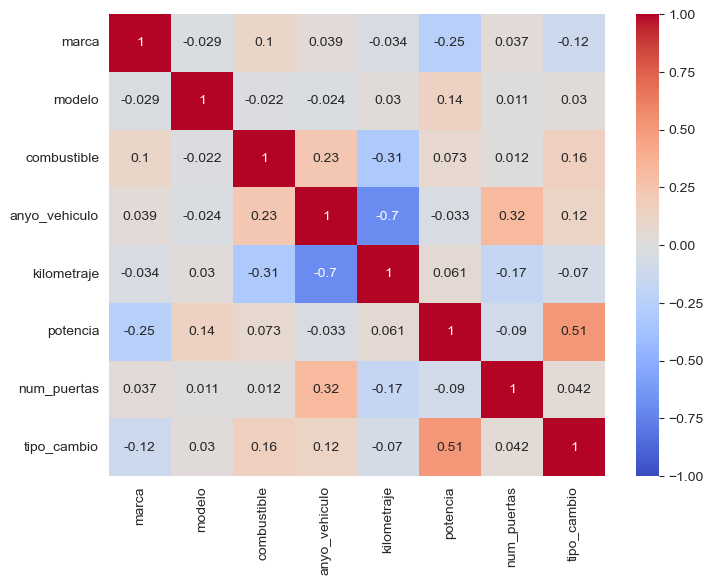

In [76]:
matriz_corr = X.corr(numeric_only=True).round(decimals=3)

plt.figure(figsize=(8, 6))

sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Vemos que la mayor correlación se da entre los kilómetros y el año del vehículo, y es negativa. Esto es lógico, ya que cuanto mayor sea el año (y más nuevo el coche), menor suele ser el número de kilómetros realizados.

Además de esto, cabe mencionar que ninguna de las correlaciones es lo suficientemente elevada como para plantearse prescindir de alguna columna.

Separamos los datos de train y test:

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32055, 8)
(8014, 8)
(32055,)
(8014,)


Vamos a escalar los datos de X entre 0 y 1:

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

# Guardamos el Scaler

with open('../include/utils/scaler.pkl', 'wb') as archivo_salida4:
    pickle.dump(scaler, archivo_salida4)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
X_train

array([[0.07692308, 0.83619048, 0.        , ..., 0.24514991, 0.        ,
        0.        ],
       [0.84615385, 0.61904762, 0.        , ..., 0.12698413, 1.        ,
        0.        ],
       [0.07692308, 0.82857143, 0.        , ..., 0.13756614, 0.        ,
        0.        ],
       ...,
       [0.53846154, 0.76380952, 0.        , ..., 0.13580247, 1.        ,
        0.        ],
       [0.38461538, 0.71619048, 0.16666667, ..., 0.05114638, 1.        ,
        0.        ],
       [0.76923077, 0.36190476, 0.        , ..., 0.06525573, 1.        ,
        0.        ]])

Comenzamos la seleción del modelo de regresión. Para ello, probamos varias parametrizaciones de modelos utilizando GridSearchCV.

In [80]:
# Importamos los modelos de regresión que utilizaremos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [66]:
# LinearRegression??

### 3.1. Linear Regression.

In [82]:
# Linear Regression

param = {}

gs_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_lin_reg.fit(X_train, y_train)

y_pred = gs_lin_reg.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.10283337181759146
RMSE: 0.32067642853442074
MAE: 0.2214054543844255
MAPE: 0.024382003851678276
r2 score: 0.8193599443134882


### 3.2. Polynomial Regression.

In [83]:
# Polynomial Regression

param = {}

for degree in range(1, 6):

    poly_feat = PolynomialFeatures(degree = degree)

    poly_feat.fit(X_train)

    X_train_poly = poly_feat.transform(X_train)
    X_test_poly = poly_feat.transform(X_test)


    gs_poly = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

    gs_poly.fit(X_train_poly, y_train)

    y_pred = gs_poly.predict(X_test_poly)

    print(f"Poly Degree {degree}:")

    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

    print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")
    print(" ")

Poly Degree 1:
MSE: 0.10283337181759743
RMSE: 0.32067642853443007
MAE: 0.22140545438443604
MAPE: 0.024382003851680302
r2 score: 0.8193599443134778
 
Poly Degree 2:
MSE: 0.0831222246944356
RMSE: 0.2883092518363495
MAE: 0.19817829857903607
MAPE: 0.02186302684966606
r2 score: 0.8539851117181692
 
Poly Degree 3:
MSE: 0.06712286687427235
RMSE: 0.2590808114744748
MAE: 0.17848184691149366
MAPE: 0.019700560148579176
r2 score: 0.8820900433809109
 
Poly Degree 4:
MSE: 0.06774316627194182
RMSE: 0.2602751741368005
MAE: 0.16732133680211708
MAPE: 0.018512688053845195
r2 score: 0.881000407635658
 
Poly Degree 5:
MSE: 140362.6824689779
RMSE: 374.65008003332645
MAE: 5.4718085563788215
MAPE: 0.5396860545739913
r2 score: -246564.12112118545
 


In [85]:
# El mejor es el de grado 3:

degree = 3
poly_feat = PolynomialFeatures(degree = degree)

poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_test_poly = poly_feat.transform(X_test)


best_poly_model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

best_poly_model.fit(X_train_poly, y_train)

y_pred = best_poly_model.predict(X_test_poly)

print(f"Poly Degree {degree}:")

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

Poly Degree 3:
MSE: 0.06712286687427235
RMSE: 0.2590808114744748
MAE: 0.17848184691149366
MAPE: 0.019700560148579176
r2 score: 0.8820900433809109


### 3.3. RandomForest.

In [86]:
# RandomForest

param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

gs_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_rf.fit(X_train, y_train)

y_pred = gs_rf.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04360568955213216
RMSE: 0.20881975374023445
MAE: 0.1324196141107834
MAPE: 0.014792353297635341
r2 score: 0.9234009927932908


In [87]:
gs_rf.best_params_

{'max_depth': 33, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}

### 3.4. ADA Boost Regression.

In [88]:
# ADA

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_ada = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_ada.fit(X_train, y_train)

y_pred = gs_ada.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.10925070972987888
RMSE: 0.3305309512434182
MAE: 0.24644560289867365
MAPE: 0.02689448584710669
r2 score: 0.8080870641448691


In [89]:
gs_ada.best_score_

-0.11333781125350487

In [90]:
gs_ada.best_params_

{'learning_rate': 0.5, 'n_estimators': 50, 'random_state': 42}

### 3.5. Gradient Boosting Regression.

In [91]:
# Gradient Boost

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_gb.fit(X_train, y_train)

y_pred = gs_gb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.039103911995005604
RMSE: 0.1977470909899956
MAE: 0.13157889226463584
MAPE: 0.01463488167401941
r2 score: 0.931308944601485


### 3.6. XGradient Boosting Regression.

In [81]:
# XG Boost

param = {}

gs_xgb = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_xgb.fit(X_train, y_train)

y_pred = gs_xgb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.03918003316121127
RMSE: 0.1979394684271211
MAE: 0.13209523939037449
MAPE: 0.014707444219127029
r2 score: 0.9311752279737087


### 3.7. Voting.

In [93]:
# Voting

# param = {"estimators":[gs_lin_reg.best_estimator_, best_poly_model.best_estimator_, gs_rf.best_estimator_, gs_ada.best_estimator_, gs_gb.best_estimator_, gs_xgb.best_estimator_],
#          "n_jobs":[-1]}

gs_voting = VotingRegressor(estimators=[("lin_reg", gs_lin_reg.best_estimator_), ("rf", gs_rf.best_estimator_), ("ada", gs_ada.best_estimator_), ("gb", gs_gb.best_estimator_), ("xgb", gs_xgb.best_estimator_)],
                            n_jobs=-1,)

gs_voting.fit(X_train, y_train)

y_pred = gs_voting.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04645409849846597
RMSE: 0.2155321286919098
MAE: 0.14491758511553005
MAPE: 0.0160843142855933
r2 score: 0.9183973957937059


El Voting da peor. El modelo con mejores métricas es el Gradient Boosting Regressor, aunque el XGradient Boosting y el RandomForest también estaba cerca. 

## 4. Selección y análisis del mejor modelo.

### 4.1. Selección de modelo:

Vamos a comparar en una tabla el resultado obtenido para el MSE de test en cada modelo, ya que es la métrica que estamos utilizando, con el fin de elegir el mejor:

In [94]:
import pandas as pd

In [95]:
df_comp_modelos_log = pd.DataFrame({"Modelo":["Linear Regression", "Polynomial Regression (grado 5)", "RandomForest", "ADA Boost", "Gradient Boost", "XG Boost", "Voting"],
                                "MAE":[0.2387, 0.1714, 0.1432, 0.2685, 0.1407, 0.1376, 0.1561],
                                "RMSE":[0.3385, 0.2669, 0.2290, 0.3594, 0.2108, 0.2135, 0.2313],
                                "r2 score":[0.8351, 0.8975, 0.9245, 0.8142, 0.9361, 0.9344, 0.9230]})

df_comp_modelos_log = df_comp_modelos_log.sort_values("MAE", ascending=True).reset_index(drop=True)
df_comp_modelos_log

,Modelo,MAE,RMSE,r2 score
0,XG Boost,0.1376,0.2135,0.9344
1,Gradient Boost,0.1407,0.2108,0.9361
2,RandomForest,0.1432,0.2290,0.9245
3,Voting,0.1561,0.2313,0.9230
4,Polynomial Regression (grado 5),0.1714,0.2669,0.8975
5,Linear Regression,0.2387,0.3385,0.8351
6,ADA Boost,0.2685,0.3594,0.8142


Vemos que el mejor modelo es el Gradient Boost, aunque está muy cerca el XGBoost. Vamos a quedarnos con el XGBoost, ya que su tiempo de entrenamiento es mucho menor y los resultados muy similares, y también con el RandomForest, ya que su funcionamiento es distinto y sus resultados están bastante cerca, por lo que puede sernos útil para comparar.

Cabe destacar que el MAE representado en la tabla anterior no se corresponde con el error medio en la predicción del modelo sobre el precio del vehículo, ya que hemos aplicado una transformación logarítmica a este precio. Más adelante veremos el MAE y el MSE reales del mejor modelo, una vez aplicada la transformación inversa. 

Vamos a ver si podemos mejorar algo de estos dos modelos mirando la importancia de las columnas (features) y realizando alguna modificación. Comenzamos con el RandomForest:

In [96]:
gs_rf.best_estimator_.feature_importances_

array([0.02667992, 0.03551855, 0.0061509 , 0.58391437, 0.07740788,
       0.25980371, 0.00369435, 0.00683032])

Realizamos un dataframe con la importancia de las cada columna en el modelo RandomForest:

In [97]:
df_feat_imp_rf = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, index=X.columns)
df_feat_imp_rf = df_feat_imp_rf.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp_rf

,Feature Importance
anyo_vehiculo,0.583914
potencia,0.259804
kilometraje,0.077408
modelo,0.035519
marca,0.026680
tipo_cambio,0.006830
combustible,0.006151
num_puertas,0.003694


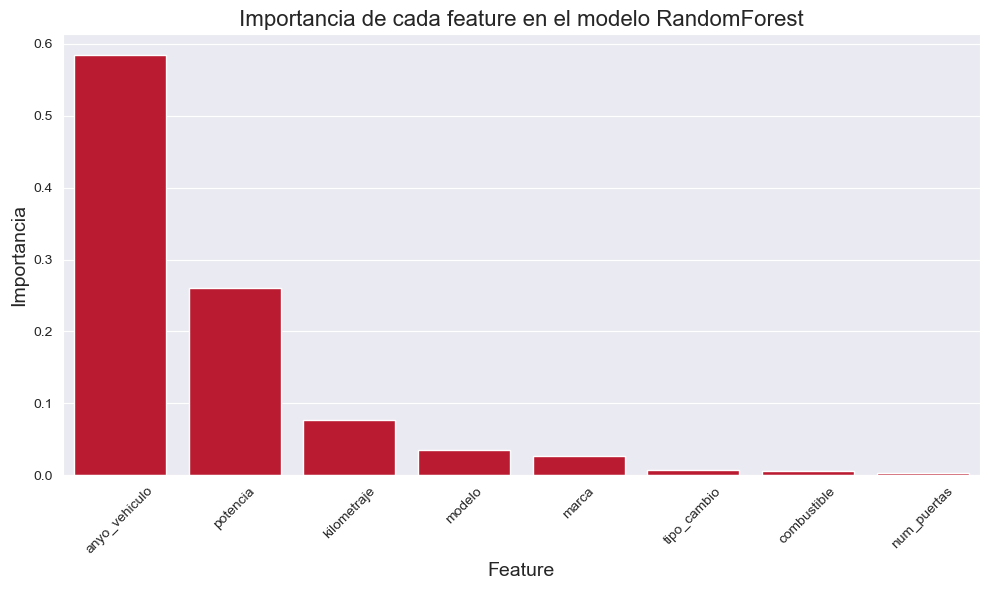

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 


df_feat_imp_rf = df_feat_imp_rf.reset_index() 
df_feat_imp_rf.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo Random Forest", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa cómo las columnas con más importancia en el precio de un coche de segunda mano son, según nuestro modelo RandomForest, el año de matriculación, potencia del motor y kms recorridos. Las columnas de modelo y marca del coche también tienen algo de importancia, y las demás (tipo de cambio, combustible y número de puertas) tienen una importancia mucho menor.

Por esto, vamos a probar a hacer un Random Forest, con la misma parametrización que el mejor de antes, pero quitando las columnas menos importantes: ```["tipo_cambio", "combustible", "num_puertas"]```, a ver si mejora el modelo.

In [99]:
# RF 2

X_rf_2 = X.drop(columns=["tipo_cambio", "combustible", "num_puertas"])
X_rf_2

,marca,modelo,anyo_vehiculo,kilometraje,potencia
0,0,67,2023,46273,110.0
1,4,281,2022,103209,120.0
2,12,110,2020,110745,122.0
3,7,299,2022,63000,114.0
4,7,401,2022,62765,140.0
...,...,...,...,...,...
40064,5,454,2012,195000,136.0
40065,7,401,2016,79983,110.0
40066,7,401,2018,88644,130.0
40067,7,504,2018,36463,130.0


In [100]:
from sklearn.model_selection import train_test_split

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf_2, y, test_size=0.2, random_state=42)

print(X_train_rf2.shape)
print(X_test_rf2.shape)
print(y_train_rf2.shape)
print(y_test_rf2.shape)

(32055, 5)
(8014, 5)
(32055,)
(8014,)


In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_rf2)
X_train_rf2 = scaler.transform(X_train_rf2)
X_test_rf2 = scaler.transform(X_test_rf2)

In [102]:
# RandomForest

# param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

rf2 = RandomForestRegressor(n_estimators=300, max_depth=33, n_jobs=-1, random_state=42)

rf2.fit(X_train_rf2, y_train_rf2)

y_pred_rf2 = rf2.predict(X_test_rf2)

print(f"MSE: {metrics.mean_squared_error(y_test_rf2, y_pred_rf2)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_rf2, y_pred_rf2))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_rf2, y_pred_rf2)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_rf2, y_pred_rf2)}")

print(f"r2 score: {metrics.r2_score(y_test_rf2, y_pred_rf2)}")

MSE: 0.045789410745480624
RMSE: 0.21398460399169053
MAE: 0.1363822237600209
MAPE: 0.015237199018859159
r2 score: 0.9195650053993346


### 4.2. Análisis del modelo definitivo:

Obtenemos un MSE más elevado que antes, por lo que no mejora. Nos quedamos entonces el XG Boost, que es el modelo con el MSE más bajo y el más rápido de entrenar. Vamos a ver la importancia de las features en este modelo:

In [82]:
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.03918003316121127
RMSE: 0.1979394684271211
MAE: 0.13209523939037449
MAPE: 0.014707444219127029
r2 score: 0.9311752279737087


In [83]:
X.columns

Index(['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje',
       'potencia', 'num_puertas', 'tipo_cambio'],
      dtype='object')

In [84]:
xgb_model.feature_importances_

array([0.03992769, 0.01954857, 0.02404037, 0.4314999 , 0.04179911,
       0.18714537, 0.01969847, 0.23634051], dtype=float32)

In [85]:
df_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X.columns)
df_feat_imp = df_feat_imp.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp

,Feature Importance
anyo_vehiculo,0.431500
tipo_cambio,0.236341
potencia,0.187145
kilometraje,0.041799
marca,0.039928
combustible,0.024040
num_puertas,0.019698
modelo,0.019549


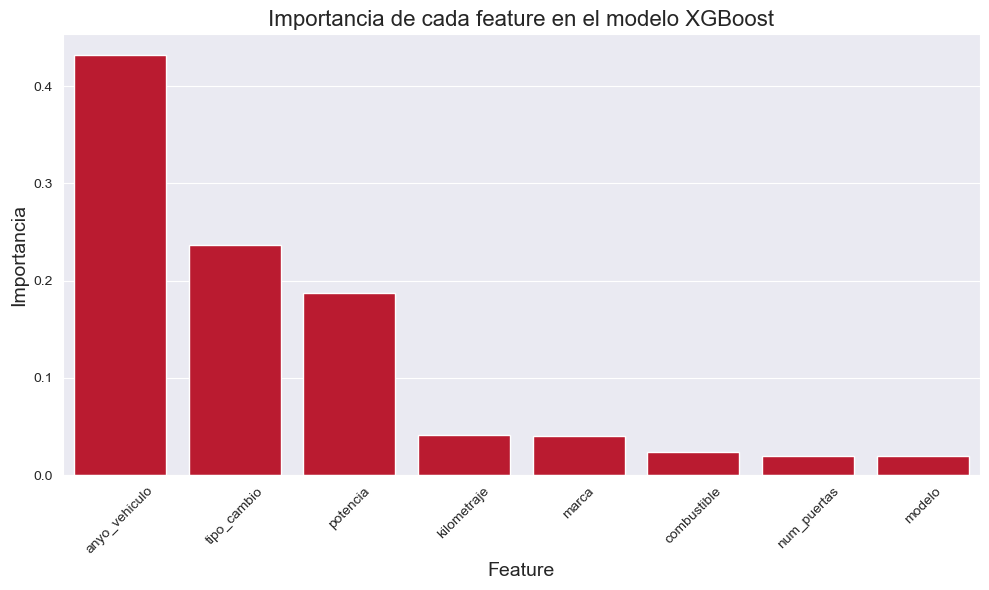

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

df_feat_imp = df_feat_imp.reset_index()
df_feat_imp.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo XGBoost", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importancia", fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


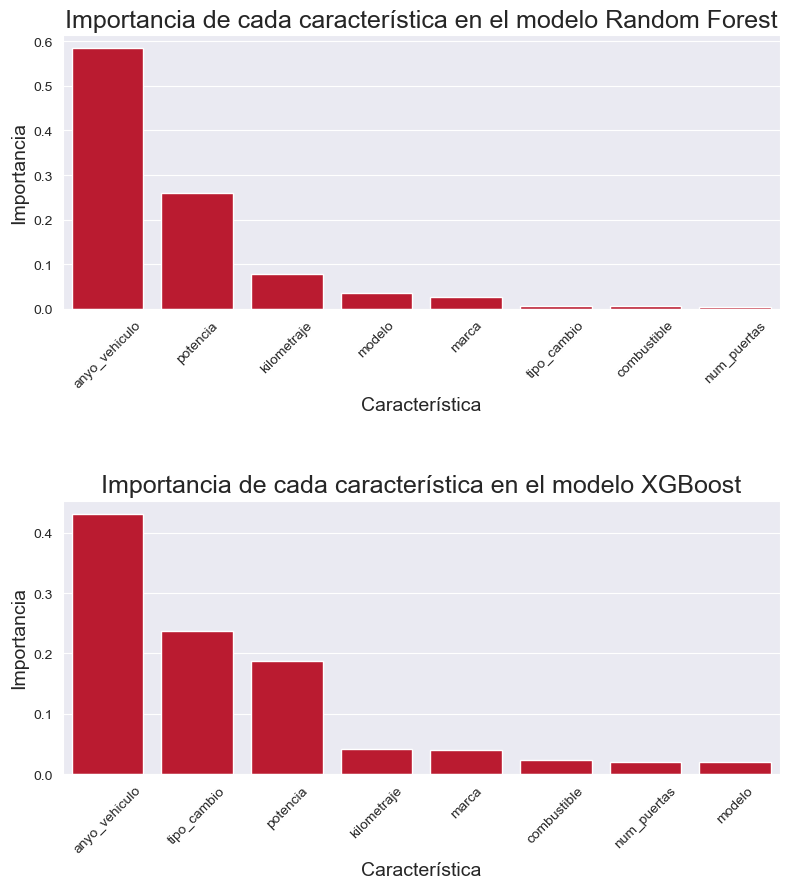

In [119]:
# Comparativa entre importancias del Randomforest y XG Boost:

import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que estos DataFrames ya tienen una columna 'Feature'
# Si no, usa reset_index() solo si el índice representa las features

# Crear la figura y los subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))

# Gráfico 1 - RandomForest
sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0], ax=axes[0])
axes[0].set_title("Importancia de cada característica en el modelo Random Forest", fontsize=18)
axes[0].set_xlabel("Característica", fontsize=14)
axes[0].set_ylabel("Importancia", fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2 - XGBoost
sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0], ax=axes[1])
axes[1].set_title("Importancia de cada característica en el modelo XGBoost", fontsize=18)
axes[1].set_xlabel("Característica", fontsize=14)
axes[1].set_ylabel("Importancia", fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)  # aumenta el espacio vertical entre subplots
plt.show()


Ahora observamos que las columnas más importantes siguen siendo ```"anyo_vehiculo"``` y ```"potencia"```. Sin embargo, el XGBoost le da mucha más importancia a la columna ```"tipo_cambio"``` que el RandomForest previo, y menos a la columna ```"kilometraje"```. Además la importancia de las columnas menos importantes es más elevada que en el anterior modelo, por lo que no descartaremos ninguna de estas columnas.

Vamos a deshacer la transformación que realizamos en la columna ```"precio"``` (target) para ver la dimensión real de nuestras métricas:

In [87]:
y_pred = xgb_model.predict(X_test)

# Deshacemos la transformación logarítmica:
y_test_final = np.exp(y_test)
y_pred_final = np.exp(y_pred)

# Claculamos las métricas reales:
print(f"MSE: {metrics.mean_squared_error(y_test_final, y_pred_final)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_final, y_pred_final)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_final, y_pred_final)}")

print(f"r2 score: {metrics.r2_score(y_test_final, y_pred_final)}")

MSE: 7025886.811733203
RMSE: 2650.638944053528
MAE: 1682.0332942893149
MAPE: 0.1376904105939662
r2 score: 0.9264542347829591


Vemos que el MAE = 1.682 euros. Esto significa que para cada vehículo nos podemos ir esa cantidad de dinero de media en la predicción. 

El RMSE es algo mayor, 2.650 euros, lo cual se debe a que existen unos pocos coches cuyo error es alto, y al hacer el error cuadrático este error se hace más grande.

En cuanto al MAPE, nos indica que nuestro modelo tiene un % de error medio del 14.05% sobre el precio del vehículo, el cual es algo elevado.

Vamos a exportar el modelo final:

In [88]:
import pickle

# Guardamos el modelo final:

with open("../include/model/modelo_final.pkl", 'wb') as archivo_salida:
    pickle.dump(xgb_model, archivo_salida)


Creamos una función que nos permita meter nuevos inputs en el formato de nuestro DataFrame inicial y extraer las variables para pasar directamente al modelo.

Además, creamos otras dos funciones: una para realizar predicciones y otra para destransformar la columna target ```"precio"```.

In [122]:
# Función para transformar un df con nuevos inputs de la base de datos en X, y para pasar al modelo.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle



def new_input_clean(input_df):
    '''
    Introduce los nuevos inputs en formato DataFrame con las columnas iniciales y devuelve los datos listos para introducirlos al modelo.

    El input DataFrame debe contener al menos las columnas (['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 
    'num_puertas', 'tipo_cambio'])
    '''

    excepciones = ['marca', 'modelo', 'precio', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 'num_puertas', 'tipo_cambio']

    # Reemplazar NaN con 0 excepto en las columnas de excepciones (las que utiliza el modelo)
    input_df = input_df.fillna({col: 0 for col in input_df.columns if col not in excepciones})


    input_df = input_df[excepciones]
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
    input_df = input_df.dropna()

    # Importamos los encodings hechos antes:
    encoder_marca = pickle.load(open("../include/utils/label_encoder_marca.pkl", 'rb'))
    encoder_modelo = pickle.load(open("../include/utils/label_encoder_modelo.pkl", 'rb'))

    list(encoder_marca.classes_)
    input_df["marca"] = encoder_marca.transform(input_df["marca"])

    list(encoder_modelo.classes_)
    input_df["modelo"] = encoder_modelo.transform(input_df["modelo"])

    tipos_combustible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
    input_df["combustible"] = input_df["combustible"].map(tipos_combustible)

    num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
    
    input_df["num_puertas"] = input_df["num_puertas"].map(num_puertas)
    
    input_df["tipo_cambio"] = input_df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

    input_df["precio"] = np.log(input_df["precio"])

    X_input = input_df.drop("precio", axis=1)
    y_input = input_df["precio"]
    

    scaler = pickle.load(open("../include/utils/scaler.pkl", 'rb'))

    X_input = scaler.transform(X_input)

    return [X_input, y_input]

# Función para hacer predicciones

def predict(loaded_model, X_input):
    return loaded_model.predict(X_input)

# Función para deshacer la transformación y devolver el precio:

import numpy as np

def destransformar_y(y_out):
    return np.exp(y_out)

Vamos ahora a cargar el modelo y probarlo con un DataFrame de prueba con coches, para ver el precio que predice. 

In [123]:
import pickle

loaded_model = pickle.load(open("../include/model/modelo_final.pkl", 'rb'))

In [124]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [126]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
where
    marca in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT', 'HYUNDAI', 'KIA', 'NISSAN', 'TOYOTA')
order by
    fecha_carga desc
;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df_prueba = df.head()

df_prueba

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,Híbrido,2023.0,46273,110.0,5.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,Híbrido,2022.0,103209,120.0,5.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,Híbrido,2020.0,110745,122.0,5.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,Gasolina,2022.0,63000,114.0,5.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,Híbrido,2022.0,62765,140.0,5.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


In [127]:
X_input, y_input = new_input_clean(input_df=df_prueba)

In [128]:
predictions = loaded_model.predict(X_input)
predictions

array([10.135457 ,  9.659866 ,  9.868817 ,  9.8552475,  9.969394 ],
      dtype=float32)

In [129]:
y_prueba = destransformar_y(predictions).round(0)
y_prueba

array([25222., 15676., 19318., 19058., 21363.], dtype=float32)

Insertamos las predicciones realizadas en la columna ```"precio_predicho"```, al lado de la columna target ```"precio"```:

In [130]:
df_prueba.insert(4, "precio_predicho", y_prueba)
df_prueba.to_csv("../include/data/processed/df_prueba_pred.csv")
df_prueba

,pk_anuncio_id,marca,modelo,precio,precio_predicho,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60611029,AUDI,a3,25290.0,25222.0,Híbrido,2023.0,46273,110.0,5.0,...,Berlina,999.0,negro,Ciudad Real,ECO (azul/verde),WebScraping,2025-05-20,202505,2025-06-07 06:51:00,https://www.coches.net/audi-a3-sportback-30-tf...
1,60652943,HYUNDAI,i30,14850.0,15676.0,Híbrido,2022.0,103209,120.0,5.0,...,Familiar,998.0,None,A Coruña,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:24:18,https://www.coches.net/hyundai-i30-10-tgdi-48v...
2,60716264,TOYOTA,c-hr,20100.0,19318.0,Híbrido,2020.0,110745,122.0,5.0,...,Berlina,1798.0,blanco,Madrid,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:22:36,https://www.coches.net/toyota-c-hr-18-125h-act...
3,60206285,NISSAN,juke,17990.0,19058.0,Gasolina,2022.0,63000,114.0,5.0,...,SUV,999.0,None,Las Palmas,None,WebScraping,2025-06-03,202506,2025-06-03 13:21:36,https://www.coches.net/nissan-juke-digt-84-kw-...
4,60716125,NISSAN,qashqai,24390.0,21363.0,Híbrido,2022.0,62765,140.0,5.0,...,SUV,1332.0,negro,Huelva,ECO (azul/verde),WebScraping,2025-06-03,202506,2025-06-03 13:20:26,https://www.coches.net/nissan-qashqai-digt-103...


Vemos que los precios que predice el modelo se ajustan bastante a los reales.

## Idea: división en segmentos.

1. Segmento medio: hasta 30k eur.
2. Segmento premium: desde 30k eur.